# Data Exploration, Pre-Processing, and Loading

## 1 Investigation

In [26]:
import os
import nibabel as nib
import gzip
from PIL import Image

def read_image(file_path):
    nii_img = nib.load(file_path)
    image_data = nii_img.get_fdata()
    header = nii_img.header
    return image_data, header

def save_image_as_png(image_data, file_path):
    image = Image.fromarray(image_data)
    image.save(file_path)

In [13]:
image_data, _ = read_image('data/ribfrac-val-images/RibFrac421-image.nii.gz')
label_data, header = read_image('data/ribfrac-val-labels/RibFrac421-label.nii.gz')

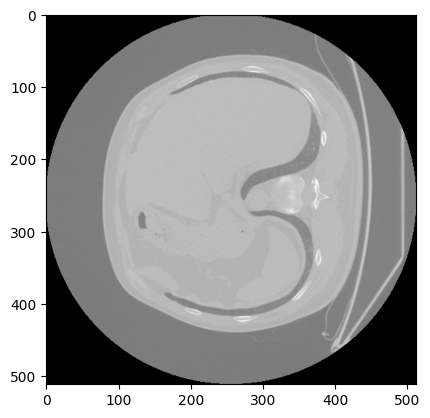

In [14]:
import matplotlib.pyplot as plt

# plot the image
plt.imshow(image_data[:,:,100], cmap='gray')
plt.show()

In [15]:
print(label_data.shape)
print(header)

(512, 512, 325)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 325   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.878906 0.878906 1.25     0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 203.6
qoffset_y       : 225.0
qoffset_z 

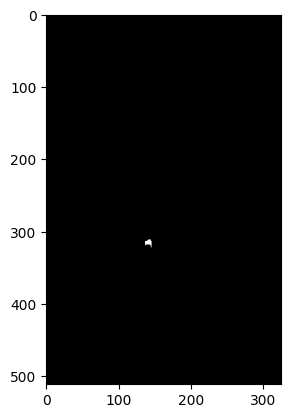

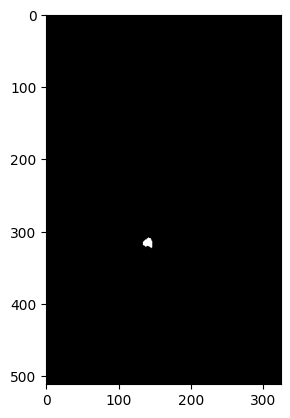

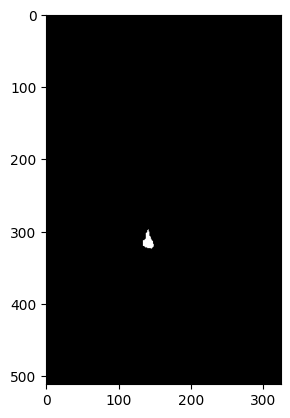

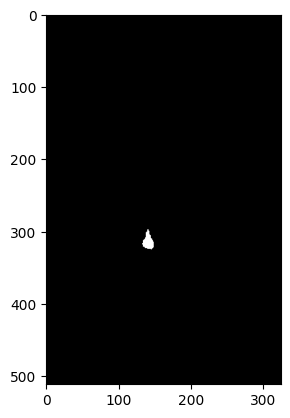

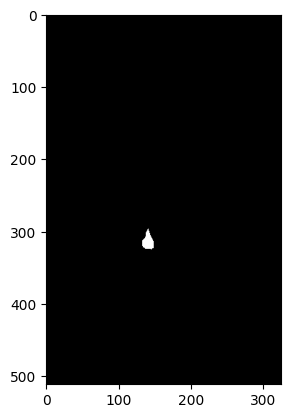

In [16]:
# plot the slices with annotation
count = 0
for slice in label_data:
    if slice.sum() > 0:
        plt.imshow(slice, cmap="gray")
        plt.show()
        count += 1
        if count == 5:
            break

## 2 Pre-Processing

In [ ]:
# loading of .nii.gz files is very slow, so we convert them to .png files

for image in os.listdir('data/ribfrac-val-images'):
    image_data, _ = read_image('data/ribfrac-val-images/' + image)
    save_image_as_png(image_data, 'data/ribfrac-val-images-png/' + image.split('.')[0] + '.png')

for label in os.listdir('data/ribfrac-val-labels'):
    label_data, _ = read_image('data/ribfrac-val-labels/' + label)
    save_image_as_png(label_data, 'data/ribfrac-val-labels-png/' + label.split('.')[0] + '.png')

## 3 Loading

In [20]:
import torch
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, labels_dir, img_dir, transform=None, target_transform=None):
        self.labels_dir = labels_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.IDs = []
        for filename in os.listdir(labels_dir):
            if filename.endswith(".nii.gz"):
                self.IDs.append(filename.split('-')[0])

    def __len__(self):
        return len(self.IDs)

    def __getitem__(self, idx):
        ID = self.IDs[idx]
        labels_path = os.path.join(self.labels_dir, f"{ID}-label.nii.gz")
        img_path = os.path.join(self.img_dir, f"{ID}-image.nii.gz")
        label = read_image(labels_path)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [23]:
from torch.utils.data import DataLoader

training_data = CustomImageDataset(labels_dir="data/ribfrac-val-labels", img_dir="data/ribfrac-val-images")
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [24]:
# test the dataloader
for X, Y in train_dataloader:
    print(X.shape)
    print(Y.shape)
    break

RuntimeError: stack expects each tensor to be equal size, but got [512, 512, 74] at entry 0 and [512, 512, 349] at entry 1